In [1]:
import pickle
import os
import numpy as np

# 读取所有文件夹中的pickle文件，分成训练和测试两个部分
def load_data(ROOT):
    X, Y = [], []
    for i in range(1, 6):
        filename = os.path.join(ROOT, 'data_batch_%d' % (i, ))
        x, y = load_pickle_file(filename)
        X.append(x)
        Y.append(y)
    X_tr = np.concatenate(X)
    Y_tr = np.concatenate(Y)
    X_te, Y_te = load_pickle_file(os.path.join(ROOT, 'test_batch'))
    return X_tr, Y_tr, X_te, Y_te

# 导入pickle文件， 并将每张图片转换成（10000， 32， 32， 3）的矩阵
def load_pickle_file(filename):
    with open(filename, 'rb') as f:
        p = pickle.load(f, encoding='latin1')
        X = p['data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('float')
        Y = np.array(p['labels'])
        return X, Y
        
X_tr, Y_tr, X_te, Y_te = load_data('./dataset/cifar-10-batches-py')
print(X_tr.shape, Y_tr.shape, X_te.shape, Y_te.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


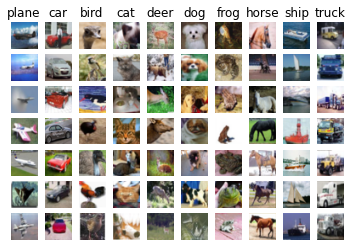

In [2]:
import matplotlib.pyplot as plt

# 展示部分数据集中的图片，每种类型展示7张
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Y_tr == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_tr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
import numpy as np

class NeuralNetwork(object):
    def __init__(
        self,
        hidden_dims,
        input_dim=3072,
        num_classes=10,
        reg=0.3,
        dtype=np.float32
    ):
        self.num_layers = len(hidden_dims)
        self.hidden_dims = hidden_dims
        self.num_classes = num_classes
        self.reg = reg
        self.dtype = dtype
        
        self.params = {'W': [], 'b': []}
        
        D_in, D_out = input_dim, hidden_dims[0]
        for i in range(self.num_layers + 1):
            self.params['W'].append(np.random.normal(scale=1e-3, size=(D_in, D_out)).astype(dtype))
            self.params['b'].append(np.zeros((D_out, )).astype(dtype))
            D_in = D_out
            if i < self.num_layers - 1:
                D_out = hidden_dims[i + 1]
            else:
                D_out = num_classes
 
    def loss(self, X, y):
        X = X.astype(self.dtype)
        out = X
        cache = []
        
        for i in range(self.num_layers):
            W, b = self.params['W'][i], self.params['b'][i]
            out, c = self.layer_forward(out, W, b)
            cache.append(c)
        
        out, c = self.nn_forward(out,
                                 self.params['W'][self.num_layers],
                                 self.params['b'][self.num_layers])
        cache.append(c)
        
        loss, d_out = self.softmax(out, y)

        grads = {'W': [0] * (self.num_layers + 1), 'b': [0] * (self.num_layers + 1)}
        
        i = self.num_layers
        # 最后一层不需要激活，分开计算
        loss += 0.5 * self.reg * np.sum(np.square(self.params['W'][i]))
        d_out, grads['W'][i], grads['b'][i] = self.nn_backward(d_out, cache.pop())
        grads['W'][i] += self.reg * self.params['W'][i]
        
        i -= 1
        
        while i >= 0:
            d_out, grads['W'][i], grads['b'][i] = self.layer_backward(d_out, cache.pop())
            loss += 0.5 * self.reg * np.sum(np.square(self.params['W'][i]))
            grads['W'][i] += self.reg * self.params['W'][i]
            i -= 1
            
        return loss, grads, out

    def train(self, data, val_data, iterations, batch_size=1000, learning_rate=1e-3):
        X, y = data
        X_val, y_val = val_data
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        for i in range(iterations):
            batch_mask = np.random.choice(X.shape[0], batch_size)
            X_batch = X[batch_mask]
            y_batch = y[batch_mask]
            
            loss, grads, scores = self.loss(X_batch, y_batch)
            self.loss_history.append(loss)
            if i % batch_size == 0:
                train_acc = self.check_acc(X, y)
                val_acc = self.check_acc(X_val, y_val)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                print("当前为第%d / %d次训练， 损失函数值为%f, 准确度为%f"
                      % (i+1000, iterations, loss, train_acc))
            
            for i in range(self.num_layers + 1):
                self.params['W'][i] -= learning_rate * grads['W'][i]
                self.params['b'][i] -= learning_rate * grads['b'][i]
        return self.loss_history
    
    def check_acc(self, X, y, batch_size=100):
        _, _, scores = self.loss(X, y)
        y_pred = np.argmax(scores, axis=1)
        acc = np.mean(y_pred == y)
        
        return acc

    
    def nn_forward(self, x, w, b):
        """
        x为神经元的输入，w为权重，b为偏置（常数项）
        返回该层神经元的输出并保存着层的参数
        """
        N, D = x.shape[0], np.prod(x.shape[1:])
        out = x.reshape(N, D).dot(w) + b
        return out, (x, w, b)
    
    def relu_forward(self, x):
        """
        激活函数，取输入和0之间的较大值
        """
        return x * (x > 0), x

    def layer_forward(self, x, w, b):
        y, cache_0 = self.nn_forward(x, w, b)
        out, cache_1 = self.relu_forward(y)
        return out, (cache_0, cache_1)
    
    def nn_backward(self, d_out, cache):
        """
        dx为前一层神经元返回的梯度，通过链式法则与本层梯度相乘
        """
        x, w, b = cache
        original_shape = x.shape
        N, D = x.shape[0], np.prod(x.shape[1:])
        
        x = x.reshape((N, D))
        dx = d_out.dot(w.T)
        dw = x.T.dot(d_out)
        db = d_out.T.dot(np.ones((N, )))
        dx = dx.reshape(original_shape)
        
        return dx, dw, db
    
    def relu_backward(self, d_out, cache):
        """
        激活函数偏导，大于零则保留
        """
        return d_out * (cache > 0)

    def layer_backward(self, d_out, cache):
        cache_0, cache_1 = cache
        d_nn = self.relu_backward(d_out, cache_1)
        dx, dw, db = self.nn_backward(d_nn, cache_0)
        return dx, dw, db

    def softmax(self, x, y):
        N = x.shape[0]
        
        shifted_x = x - np.max(x, axis=1, keepdims=True)
        sum = np.sum(np.exp(shifted_x), axis=1, keepdims=True)
        log_probs = shifted_x - np.log(sum)
        probs = np.exp(log_probs)
        loss = -np.sum(log_probs[np.arange(N), y]) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= N
        return loss, dx


In [ ]:
import matplotlib.pyplot as plt

a = NeuralNetwork([100, 100])
pred = a.train((X_tr, Y_tr), (X_te, Y_te), 100000)

当前为第1000 / 100000次训练， 损失函数值为2.350237, 准确度为0.098260
当前为第2000 / 100000次训练， 损失函数值为2.114816, 准确度为0.185400
当前为第3000 / 100000次训练， 损失函数值为2.088748, 准确度为0.221400
当前为第4000 / 100000次训练， 损失函数值为1.963728, 准确度为0.271460
当前为第5000 / 100000次训练， 损失函数值为1.925980, 准确度为0.334340
当前为第6000 / 100000次训练， 损失函数值为1.792859, 准确度为0.356880
当前为第7000 / 100000次训练， 损失函数值为1.734319, 准确度为0.407320
当前为第8000 / 100000次训练， 损失函数值为1.743330, 准确度为0.412200
当前为第9000 / 100000次训练， 损失函数值为1.789076, 准确度为0.418460
当前为第10000 / 100000次训练， 损失函数值为1.779816, 准确度为0.432740
当前为第11000 / 100000次训练， 损失函数值为1.727401, 准确度为0.461980
当前为第12000 / 100000次训练， 损失函数值为1.660127, 准确度为0.463720
当前为第13000 / 100000次训练， 损失函数值为1.649001, 准确度为0.473140
当前为第14000 / 100000次训练， 损失函数值为1.697826, 准确度为0.469780
当前为第15000 / 100000次训练， 损失函数值为1.688139, 准确度为0.473720
当前为第16000 / 100000次训练， 损失函数值为1.644395, 准确度为0.487140
当前为第17000 / 100000次训练， 损失函数值为1.691601, 准确度为0.482820
当前为第18000 / 100000次训练， 损失函数值为1.650579, 准确度为0.505440
当前为第19000 / 100000次训练， 损失函数值为1.659983, 准确度为0.468080
当前为第20000 / 100000次训练

In [ ]:
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    plt.subplot(3, 1, 1)
    plt.title('Loss', color='white')

    plt.subplot(3, 1, 2)
    title2 = plt.title('Train Accuracy', color='white')

    plt.subplot(3, 1, 3)
    plt.title('Validation Accuracy', color='white')


    plt.subplot(3, 1, 1)
    plt.plot(a.loss_history, 'o')

    plt.subplot(3, 1, 2)
    plt.plot(a.train_acc_history, '-o')

    plt.subplot(3, 1, 3)
    plt.plot(a.val_acc_history, '-o')

    plt.gcf().set_size_inches(15, 15)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

_, _, scores = a.loss(X_tr[0:10], Y_tr[0:10])
y_pred = np.argmax(scores, axis=1)

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_tr[i].astype('uint8'))
    plt.axis('off')
    plt.title(classes[y_pred[i]], color='black')
    

In [ ]:
plt.imshow(X_tr[3].astype('uint8'))
plt.show()